# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats as st

state = np.random.RandomState(12345)

In [2]:
POINTS_NUM = 500
TOP_POINTS = 200
BUDGET = 10000000000
PROFIT_PER_KBAR = 450000 

In [3]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

display(df0.head())
df0.info()

display(df1.head())
df1.info()

display(df2.head())
df2.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В трех датасетах по 100000 строк, пропусков нет. Порядки величин в столбцах отличаются, может потребоваться масштабирование. Типы данных соотвествуют содержимому. Есть один нечисловой признак - 'id'.

Проверим, нет ли дубликатов.

In [4]:
display(df0.duplicated().sum())
display(df1.duplicated().sum())
display(df2.duplicated().sum())

0

0

0

Дубликатов нет. Посмотрим, сколько есть уникальных значений id, чтобы понять, имеет ли смысл их кодировать и использовать в дальнейшем.

In [5]:
display(df0['id'].value_counts().head(11))
display(df1['id'].value_counts())
display(df2['id'].value_counts())

TtcGQ    2
74z30    2
AGS9W    2
QcMuo    2
A5aEY    2
bsk9y    2
HZww2    2
bxg6G    2
Tdehs    2
fiKDv    2
YHkBm    1
Name: id, dtype: int64

bfPNe    2
5ltQ6    2
LHZR0    2
wt4Uk    2
rmNX4    1
        ..
e6xFZ    1
Rld8J    1
eh22n    1
RyErF    1
FNcM1    1
Name: id, Length: 99996, dtype: int64

Vcm5J    2
KUPhW    2
VF7Jo    2
xCHr8    2
lZldF    1
        ..
GzwPg    1
tdOZx    1
jpZXA    1
UXR5S    1
2u1WK    1
Name: id, Length: 99996, dtype: int64

Уникальных идентификаторов почти столько же, сколько строк. Есть несколько повторяющихся названий. Посмотрим на эти строки, чтобы убедиться, что это не дубликаты.

In [6]:
display(df0[df0['id'].isin(['TtcGQ', 'fiKDv', 'bxg6G', 'A5aEY', 'AGS9W', 'QcMuo', 'HZww2', 'bsk9y',
                           'Tdehs', '74z30'])].sort_values(by='id'))
display(df1[df1['id'].isin(['bfPNe', '5ltQ6', 'wt4Uk', 'LHZR0'])].sort_values(by='id'))
display(df2[df2['id'].isin(['xCHr8', 'Vcm5J', 'KUPhW', 'VF7Jo'])].sort_values(by='id'))

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Ничего общего, кроме id. Это не дубликаты, оставляем их.

Линейная регрессия, которую необходимо использовать по условию задачи, требует чтобы все признаки были численными. Кодировать идентификаторы смысла нет, потому что они почти все разные. К тому же они не имеют никакого отношения к параметрам скважины. Поэтому для модели возьмем только численные признаки. Посмотрим корреляцию признаков с целевым *и распределение целевого.*

In [7]:
def df_corr(df):
    corr = df.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True)

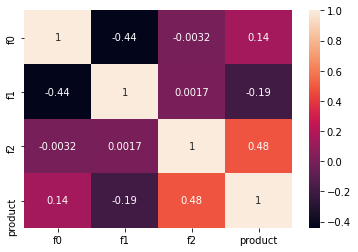

In [8]:
df_corr(df0)

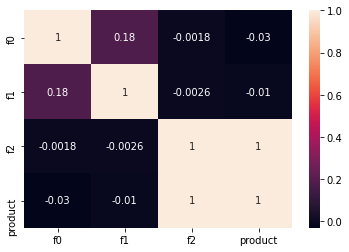

In [9]:
df_corr(df1)

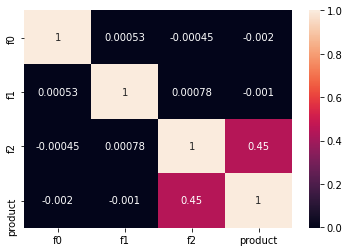

In [10]:
df_corr(df2)

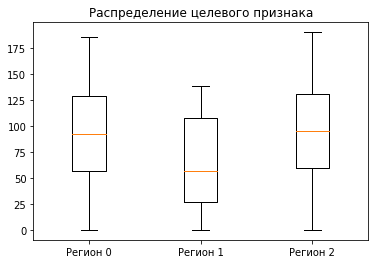

In [11]:
plt.boxplot([df0['product'], df1['product'], df2['product']], labels=['Регион 0', 'Регион 1', 'Регион 2']);
plt.title('Распределение целевого признака');

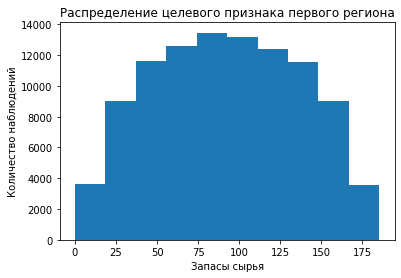

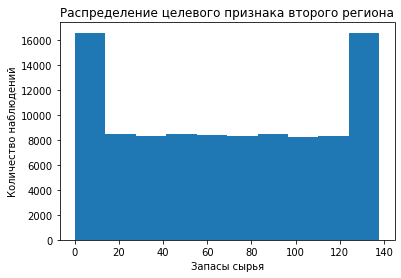

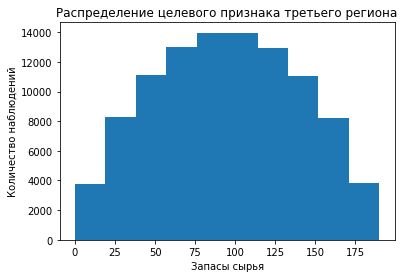

In [13]:
plt.hist(df0['product'])
plt.title('Распределение целевого признака первого региона')
plt.xlabel('Запасы сырья')
plt.ylabel('Количество наблюдений')
plt.show()

plt.hist(df1['product'])
plt.title('Распределение целевого признака второго региона')
plt.xlabel('Запасы сырья')
plt.ylabel('Количество наблюдений')
plt.show()

plt.hist(df2['product'])
plt.title('Распределение целевого признака третьего региона')
plt.xlabel('Запасы сырья')
plt.ylabel('Количество наблюдений')
plt.show()

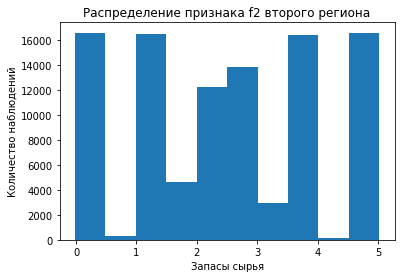

In [14]:
plt.hist(df1['f2'])
plt.title('Распределение признака f2 второго региона')
plt.xlabel('Запасы сырья')
plt.ylabel('Количество наблюдений')
plt.show()

В 1 регионе признак f2 сильно коррелирует с целевым. *Целевой признак распределен примерно одинаково во всех трех регионах, разве что в регионе 1 медиана меньше, но все распределение немного уже, чем  у остальных.* Разделим все датасеты на обучающие и валидационные выборки в соотношении 75:25 и отмасштабируем признаки.

In [12]:
numeric = ['f0', 'f1', 'f2', 'product']

def preparation (df, target_name):

    target = df[target_name]
    features = df.drop(target_name, axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    column_names = df.columns[:-1]
    scaler = StandardScaler()
    scaler.fit(features_train[column_names])
    features_train = pd.DataFrame(scaler.transform(features_train), index=features_train.index, columns=column_names)
    features_valid = pd.DataFrame(scaler.transform(features_valid), index=features_valid.index, columns=column_names)
    return features_train, target_train, features_valid, target_valid

features_train0, target_train0, features_valid0, target_valid0 = preparation (df0[numeric], 'product')
features_train1, target_train1, features_valid1, target_valid1 = preparation (df1[numeric], 'product')
features_train2, target_train2, features_valid2, target_valid2 = preparation (df2[numeric], 'product')

Данные подготовлены: проверено отсутствие явных и неявных дубликатов, визуализированы корреляции численных признаков и распределение целевого; данные отмасшабированы и разделены на выборки - обучающие и валидационные.  

В 1 регионе признак f2 сильно коррелирует с целевым. Целевой признак распределен примерно одинаково во всех трех регионах.

## Обучение и проверка модели

In [13]:
def LinearReg_train_and_check (features_train, target_train, features_valid, target_valid):
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid), index=target_valid.index)
    mean_estimated = predictions.mean()
    rmse = sqrt(mean_squared_error(target_valid, predictions))
    return predictions, mean_estimated, rmse

predictions0, mean_estimated0, rmse0 = LinearReg_train_and_check (features_train0, target_train0, 
                                                                  features_valid0, target_valid0)
predictions1, mean_estimated1, rmse1 = LinearReg_train_and_check (features_train1, target_train1, 
                                                                  features_valid1, target_valid1)
predictions2, mean_estimated2, rmse2 = LinearReg_train_and_check (features_train2, target_train2, 
                                                                  features_valid2, target_valid2)

print('Средний объем и ошибка для региона 0:', '%.2f, %.2f' % (mean_estimated0, rmse0))
print('Средний объем и ошибка для региона 1:', '%.2f, %.2f' % (mean_estimated1, rmse1))
print('Средний объем и ошибка для региона 2:', '%.2f, %.2f' % (mean_estimated2, rmse2))

Средний объем и ошибка для региона 0: 92.59, 37.58
Средний объем и ошибка для региона 1: 68.73, 0.89
Средний объем и ошибка для региона 2: 94.97, 40.03


По оценке модели, наибольший средний объем нефти во 2 регионе - 94.97т.б. Регион 0 отстает ненамного - 92.59т.б. Регион 1 имеет значительно меньшие запасы - 68.73т.б. Среднеквадратичное отклонение у 1 региона низкое из-за корреляции.

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [14]:
MIN_VOLUME = BUDGET / PROFIT_PER_KBAR / TOP_POINTS
print('Минимальный объем для безубыточной разработки:', '%.2f' % MIN_VOLUME)

Минимальный объем для безубыточной разработки: 111.11


Требуемый объем больше предсказанных средних объемов для всех трех регионов. Причем в регионе 1 средний объем скважины составляет всего 61% от необходимого. Но эти значения (92, 68, 94) - средние, т.е. это ожидаемый объем среднестатистичекой скважины в регионе, рассчитанный на основе 25000 точек, а будущая разработка предполагает только 200. Для оценки прибыли и рисков в каждом регионе воспользуемся техникой Bootstrap - рассмотрим 500 случайных точек, выберем из них 200 лучших и посчитаем прибыль на них, а потом повторим эти операции 1000 раз. Это позволит сделать вывод о том, какая вероятность соотвествует каждой возможной прибыли в регионе.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [15]:
#функция определения прибыли с лучших count точек при цене за единицу price минус инвестиции (здесь budget)
#деление на 1000000000 дает результат в млрд.руб
def revenue(target, predictions, count, price):
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    return (price * selected.sum() - BUDGET)/1000000000

Применим эту функцию, т.е. узнаем, сколько прибыли (в млрд.руб.) принесут самые лучшие скважины за вычетом вложенных 10млрд.

In [16]:
rev0 = revenue(target_valid0, predictions0, TOP_POINTS, PROFIT_PER_KBAR)
rev1 = revenue(target_valid1, predictions1, TOP_POINTS, PROFIT_PER_KBAR)
rev2 = revenue(target_valid2, predictions2, TOP_POINTS, PROFIT_PER_KBAR)
print(round(rev0,3))
print(round(rev1,3))
print(round(rev2,3))

3.321
2.415
2.71


Наибольшую прибыль обещают лучшие скважины в 0 регионе, наименьшую - в 1.

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли для каждого региона.

In [17]:
#функция для применения n итераций бутстрапа с выборками размера sample_size и отбираемыми selected_size лучшимим
#дополнительно оценивает вероятность отрицательной прибыли

def Bootstrap (target, predictions, sample_size, selected_size, n):
    profits = []
    losses = 0
    for i in range(n):
        target_subsample = target.sample(sample_size, replace=True, random_state=state)
        pred_subsample = predictions[target_subsample.index]
        rev = revenue(target_subsample, pred_subsample, selected_size, PROFIT_PER_KBAR)
        profits.append(revenue(target_subsample, pred_subsample, selected_size, PROFIT_PER_KBAR))
        if rev<0:
            losses+=1
    profits = pd.Series(profits)
    losses_prob = losses/n
    return profits, losses_prob   

0 регион
Средняя прибыль в регионе: 0.43 млрд.руб.
Доверительный 95% интервал: (-0.102; 0.948)
Вероятность убытков: 6.0%


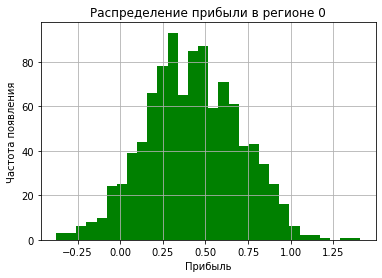

In [18]:
profits0, losses_prob_0 = Bootstrap(target_valid0, predictions0, POINTS_NUM, TOP_POINTS, 1000)
profits0.hist(bins=30, color='green');
plt.title('Распределение прибыли в регионе 0')
plt.ylabel('Частота появления')
plt.xlabel('Прибыль')
print('0 регион')
print(f'Средняя прибыль в регионе: {round(profits0.mean(), 2)} млрд.руб.')
print(f'Доверительный 95% интервал: ({round(profits0.quantile(0.025),3)}; {round(profits0.quantile(0.975),3)})')
print(f'Вероятность убытков: {round(losses_prob_0*100, 3)}%')

1 регион
Средняя прибыль в регионе: 0.52 млрд.руб.
Доверительный 95% интервал: (0.128; 0.954)
Вероятность убытков: 0.3%


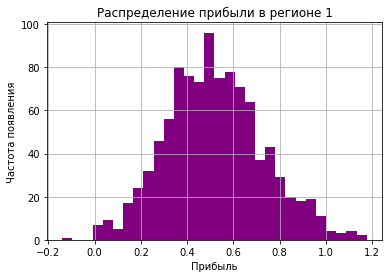

In [19]:
profits1, losses_prob_1 = Bootstrap(target_valid1, predictions1, POINTS_NUM, TOP_POINTS, 1000)
profits1.hist(bins=30, color='purple');
plt.title('Распределение прибыли в регионе 1')
plt.ylabel('Частота появления')
plt.xlabel('Прибыль')
print('1 регион')
print(f'Средняя прибыль в регионе: {round(profits1.mean(), 2)} млрд.руб.')
print(f'Доверительный 95% интервал: ({round(profits1.quantile(0.025),3)}; {round(profits1.quantile(0.975),3)})')
print(f'Вероятность убытков: {round(losses_prob_1*100, 3)}%')

2 регион
Средняя прибыль в регионе: 0.42 млрд.руб.
Доверительный 95% интервал: (-0.116; 0.99)
Вероятность убытков: 6.2%


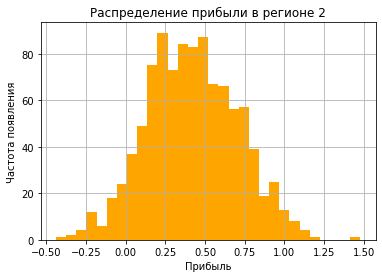

In [20]:
profits2, losses_prob_2 = Bootstrap(target_valid2, predictions2, POINTS_NUM, TOP_POINTS, 1000)
profits2.hist(bins=30, color='orange');
plt.title('Распределение прибыли в регионе 2')
plt.ylabel('Частота появления')
plt.xlabel('Прибыль')
print('2 регион')
print(f'Средняя прибыль в регионе: {round(profits2.mean(), 2)} млрд.руб.')
print(f'Доверительный 95% интервал: ({round(profits2.quantile(0.025),3)}; {round(profits2.quantile(0.975),3)})')
print(f'Вероятность убытков: {round(losses_prob_2*100, 3)}%')

Многообещающие 0 и 2 регионы не удовлетворяют требованию в отношении рисков. В 1 регионе вероятность рисков очень низка по причине сильной корреляции одного из признаков с целевым именно в этом регионе. По условию максимума средней прибыли побеждает также 1 регион.

**В результате наиболее перспективный регион для разработки - 1.**

## Вывод 

**В проекте были рассмотрены 3 датасета - 100000 строк в каждом, содержащие характеристики месторождений нефти в 3 регионах. Задачей было определить наиболее прибыльный регион для добычи при установленных условиях (бюджет, цена за баррель, число скважин, допустимый риск потерь). Данные были подготовлены (отмасштабированы, разделены на обучающую и валидационную выборки), после чего, с помощью линейной регрессии и техники Bootstrap, для каждого региона были получены: средняя прибыль, доверительный 95% интервал и вероятность убытков. По условию ограничения рисков прошел только регион 1: хоть и средний объем скважины здесь наименьший, этот регион самый предсказуемый. Чрезвычайно низкая вероятность убытков в нем вызвана очень высокой (0.99) корреляцией одного из признаков с целевым в датасете по этому региону.**

**Примечание: наличие такого сильно коррелирующего признака в остальных двух датасетах может привести к изменению результатов в сторону увеличения потенциальной прибыли, так как регионы 0 и 2 имеют, в среднем, скважины большего объема. Возможно, стоит поработать со сбором данных в этих регионах.** 